In [1]:
from core import *
import utils
import time as time
from pathlib import Path
import numpy as np

In [53]:
import GPy
#path = 'c:\Users\grufi\OneDrive\Desktop\legolas\Legolas_textCellLoc-main\plots'
#SAVE = Path(path)
#SAVE.mkdir(exist_ok=True)

def Bayesian_optimization_pH():
    # Uses GPy for Gaussian Process regression as surrogate function.

    # If True, this will simulate deposition and measurement
    simulate_val = True
    
    # X_grid is the list of all possible acid-base ratios that can be investigated.
    # This is the array that will be index with next_sample_index
    X_grid = np.linspace(0.1,1,20)[:,None]
    other = np.linspace(1.1,10,20)[:,None]
    X_grid = np.append(X_grid,other)[:,None] # set of all acid and base ratios
    Dsize = X_grid.shape[0] # number in X_grid set
    print(f'x grid: {X_grid}, Dsize : {Dsize}')
    BO_lambda = .1
    
    # # set up GP.
    # X_samples = np.atleast_1d([1.])[:,None] # ratio of R to G
    # Y_samples = np.atleast_1d([210.])[:,None]
    # measured = np.asarray([14])
    # unmeasured = np.setdiff1d(np.linspace(0,14,15), measured).astype(int)
    
    # set up variables
    ratio = [1] # ratio of initial sample to study, 0 is no acid
    sample_index = 0 # index of ratio in list of ratios
    count = 0 #counter for moving to appropriate well

    # deposit first ratio in well and collect pH
    pH = BO_get_data(ratio,count) 
    print('counter value:',count)
    print('Acid/Base ratio measured:',ratio)
    print('pH Value:',pH)
    
    measured = np.atleast_1d(sample_index) # indices of ratios that have been measured
    full_indices = np.linspace(0,X_grid.shape[0]-1,X_grid.shape[0]) # indices of all ratios to be investigated
    unmeasured = np.setdiff1d(full_indices, measured).astype(int)  # indices of ratios that are still to be measured
    X_samples = np.atleast_1d(ratio)[:,None] # X_samples is the RG ratios already studied
    Y_samples = np.atleast_1d(pH)[:,None] # Y_samples are the corresponding Red measurements for the RG ratios studied.
    
    # iteration loop for active learning (GP with exploration CO)
    for iterations in range(30):
        #reset(stage=stage, pH_device=pH_device, depo_device=depo_device)
        """
        if iterations in home_check:
            # Go to Home Position
            time.sleep(10)
            reset(stage=stage, pH_device=pH_device, depo_device=depo_device)
        """
        # Regression
        k = GPy.kern.RBF(1)
        m = GPy.models.GPRegression(X_samples, Y_samples, k)
        #blockPrint() # blocks printing statements to avoid printing GPy's optimization statements.
        m.optimize_restarts(5, robust=True);
        #enablePrint() # restarts the internal printing statements
        mean_full, variance_full = m.predict(X_grid) # Prediction
        mean, variance = m.predict(X_grid[unmeasured]) # Prediction just for unmeasured ratios
        
        # # Bayesian optimization to maximize measured red by varying mixture.
        # BO_beta = 2 * math.log(Dsize * math.pow(iterations + 1,2) * math.pow(np.pi,2) / (6 * BO_lambda) )
        # alpha = -1 * np.abs(100. - mean) + math.sqrt(BO_beta) * variance
        
        # Active Learning
        alpha_full = variance_full # variance for all ratios. use variance (uncertainty) in Gaussian Process to guide next sample
        alpha = variance # variance for unmeasured ratios
        ##alpha = (9/(iterations+1))*variance - np.absolute(mean-4.75)
        ##alpha_full = (9/(iterations+1))*variance_full - np.absolute(mean_full-4.75)
        sample_index = unmeasured[ np.argmax(alpha) ] # index of next ratio in X_grid
        ratio = X_grid[sample_index,:] # next ratio
        print('The next ratio to investigate is', ratio)

        # plot
        plt.figure(figsize = (7,3))
        num_subplots = 2
        if ~simulate_val:
            num_subplots = 3

        
        plot_gp(X_grid, mean_full, variance_full, training_points=(X_samples,Y_samples)) # plot GP variance for all ratios
        
        plt.figure(figsize = (10,5))
        plt.subplot(1,num_subplots,2)
        plt.plot(X_grid, alpha_full)  # plot the aquisition function for all ratios
        plt.plot([ratio, ratio],[np.min(alpha_full), np.max(alpha_full)],'m') # indicate the next ratio to be investigated
        plt.title(f'Acquisition func')
        #plt.tight_layout()
        #plt.savefig(SAVE/f"Acquisition{iterations}.png", facecolor='white')
        #plt.show()
        #plt.close()
        
        #plt.figure(figsize = (10,5))
        plt.subplot(1,num_subplots,1)
        bottom, top = plt.ylim()
        plt.plot([ratio, ratio],[bottom, top],'m') # indicate the next ratio to investigate
        plt.title(f'Next ratio:{ratio}')
        #plt.tight_layout()
        #plt.savefig(SAVE/f"GP{iterations}.png", facecolor='white')
        plt.show()
        #plt.close()
        
        '''
        plt.figure(figsize = (20,5))
        plt.subplot(1,num_subplots,3)
        bottom, top = plt.ylim()
        plt.plot([ratio, ratio],[bottom, top],'m') # indicate the next ratio to investigate
        plt.title(f'Next ratio:{ratio}')
        #plt.tight_layout()
        #plt.savefig(SAVE/f"GP{iterations}.png", facecolor='white')
        plt.show()
        #plt.close()
        '''
           
        count+=1           #move to next well
        
        # collect data
        pH = BO_get_data(ratio, count) # run the next experiment.
        print('counter value:',count)
        print('Acid/Base ratio measured:',ratio)
        print('pH Value:',pH)
        measured = np.append(measured, sample_index) # add experiment ratio to the set of measured
        unmeasured = np.setdiff1d(full_indices, measured).astype(int)
        X_samples = np.append(X_samples, ratio)[:,None]
        Y_samples = np.append(Y_samples, pH)[:,None]
    
def BO_get_data(ratio, count):

    acid_vol,base_vol = ratio_conversion(ratio)
    print('acid_vol', acid_vol)
    print('base_vol', base_vol)
    
   
    

    pH = 4.74 - np.log10(ratio)
    print(f"pH (HH) {pH}")
    
    #pH_device.move_to_loc("clean")
    #pH_device.to_zpos("full_down")
    #pH_device.to_zpos("full_up")

    return pH



def ratio_conversion(ratio):
    acid_vol = float(2.0*ratio[0]/(1+ratio[0]))
    base_vol = float(2.0 - acid_vol)
    return acid_vol,base_vol
            
    
def plot_gp(X, m, C, training_points=None):
    # plot results of Gaussian Process analysis.
    # Plot 95% confidence interval 
    plt.fill_between(X[:,0], m[:,0] - 1.96*np.sqrt(np.diag(C)), m[:,0] + 1.96*np.sqrt(np.diag(C)), alpha=0.5)
    #alpha is opacity
    plt.title('GP model for pH')
    plt.plot(X, m, "-")  # Plot GP mean 
    plt.xlabel("x"), plt.ylabel("f")
    #plt.savefig(SAVE/f"gp{iterations}.png", facecolor='white')
    if training_points is not None:  # Plot training points if included
        X_, Y_ = training_points
        plt.plot(X_, Y_, "kx", mew=2)
        plt.show()

x grid: [[ 0.1       ]
 [ 0.14736842]
 [ 0.19473684]
 [ 0.24210526]
 [ 0.28947368]
 [ 0.33684211]
 [ 0.38421053]
 [ 0.43157895]
 [ 0.47894737]
 [ 0.52631579]
 [ 0.57368421]
 [ 0.62105263]
 [ 0.66842105]
 [ 0.71578947]
 [ 0.76315789]
 [ 0.81052632]
 [ 0.85789474]
 [ 0.90526316]
 [ 0.95263158]
 [ 1.        ]
 [ 1.1       ]
 [ 1.56842105]
 [ 2.03684211]
 [ 2.50526316]
 [ 2.97368421]
 [ 3.44210526]
 [ 3.91052632]
 [ 4.37894737]
 [ 4.84736842]
 [ 5.31578947]
 [ 5.78421053]
 [ 6.25263158]
 [ 6.72105263]
 [ 7.18947368]
 [ 7.65789474]
 [ 8.12631579]
 [ 8.59473684]
 [ 9.06315789]
 [ 9.53157895]
 [10.        ]], Dsize : 40
acid_vol 1.0
base_vol 1.0
pH (HH) [4.74]
counter value: 0
Acid/Base ratio measured: [1]
pH Value: [4.74]
Optimization restart 1/5, f = 2.9749756689647193
Optimization restart 2/5, f = 2.9749756742564077
Optimization restart 3/5, f = 2.974975668943419
Optimization restart 4/5, f = 2.974975710770676
Optimization restart 5/5, f = 2.9749756689320366
The next ratio to investigate i

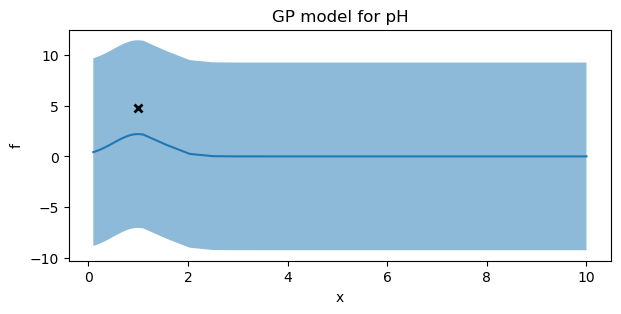

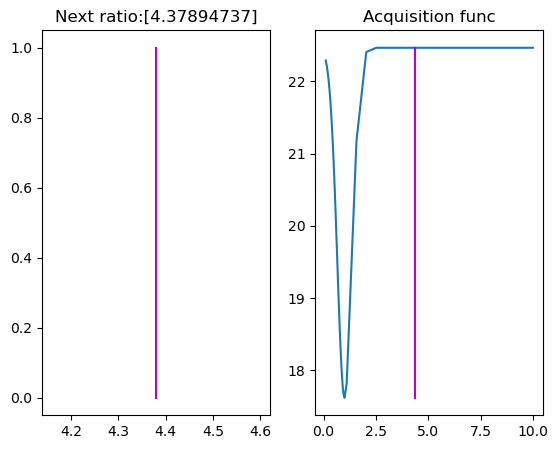

acid_vol 1.6281800391389432
base_vol 0.37181996086105684
pH (HH) [4.09863027]
counter value: 1
Acid/Base ratio measured: [4.37894737]
pH Value: [4.09863027]
Optimization restart 1/5, f = 3.879712613854082
Optimization restart 2/5, f = 5.815098318901291
Optimization restart 3/5, f = 5.815098316397665
Optimization restart 4/5, f = 3.879712611626359
Optimization restart 5/5, f = 3.8797126106071715
The next ratio to investigate is [10.]


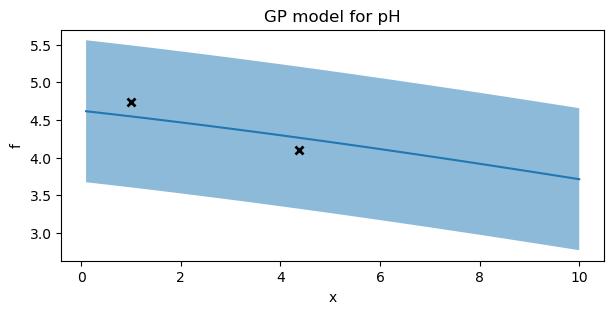

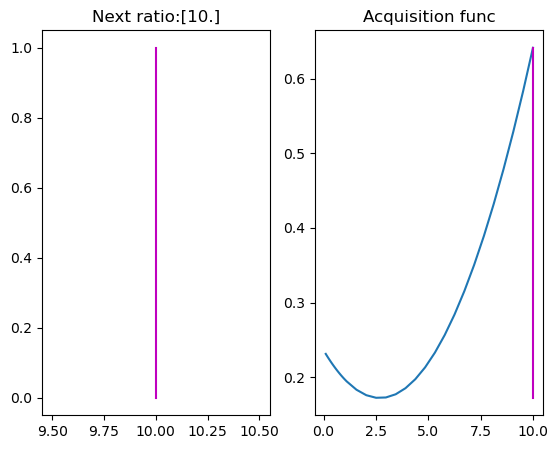

acid_vol 1.8181818181818181
base_vol 0.18181818181818188
pH (HH) [3.74]
counter value: 2
Acid/Base ratio measured: [10.]
pH Value: [3.74]
Optimization restart 1/5, f = 4.383253700283919
Optimization restart 2/5, f = 4.3832537009257155
Optimization restart 3/5, f = 4.383253700287681
Optimization restart 4/5, f = 8.571505704631294
Optimization restart 5/5, f = 8.571505325602306
The next ratio to investigate is [0.14736842]


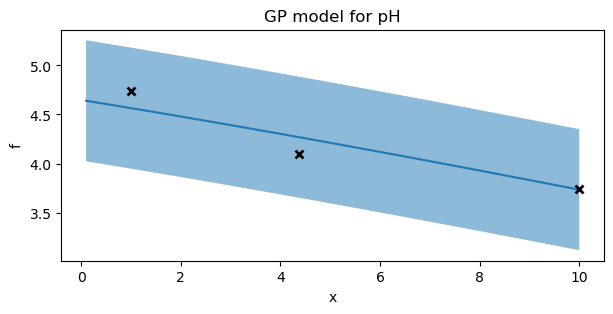

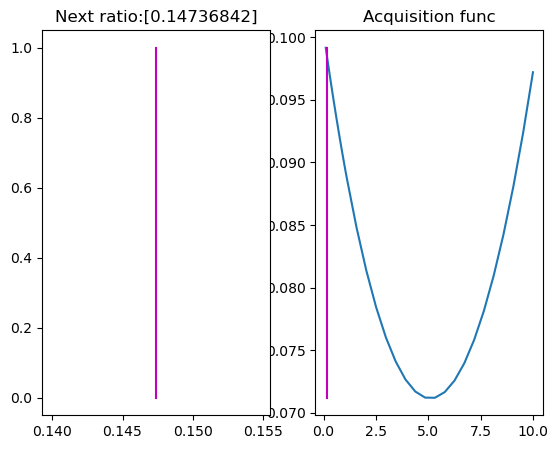

acid_vol 0.25688073394495414
base_vol 1.7431192660550459
pH (HH) [5.57159557]
counter value: 3
Acid/Base ratio measured: [0.14736842]
pH Value: [5.57159557]
Optimization restart 1/5, f = 6.590232521933363
Optimization restart 2/5, f = 6.59023252208284
Optimization restart 3/5, f = 6.590232522189835
Optimization restart 4/5, f = 6.590232522204248
Optimization restart 5/5, f = 6.590232521973915
The next ratio to investigate is [9.53157895]


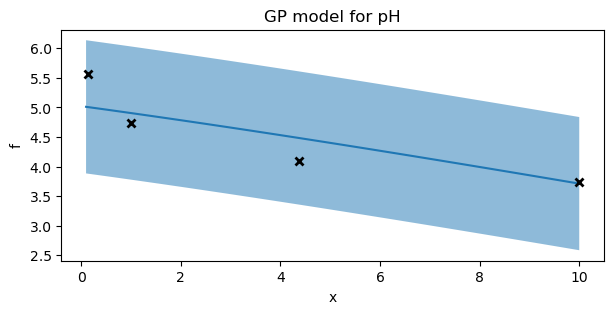

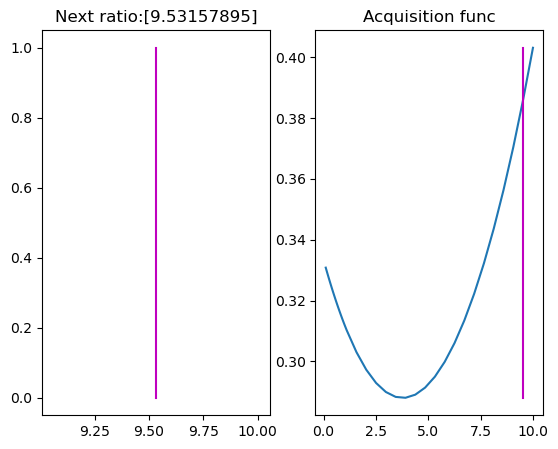

acid_vol 1.8100949525237382
base_vol 0.1899050474762618
pH (HH) [3.76083515]
counter value: 4
Acid/Base ratio measured: [9.53157895]
pH Value: [3.76083515]
Optimization restart 1/5, f = 6.93084964243663
Optimization restart 2/5, f = 6.930849642488703
Optimization restart 3/5, f = 6.930849642439737
Optimization restart 4/5, f = 6.930849644706893
Optimization restart 5/5, f = 6.930849643156595
The next ratio to investigate is [0.19473684]


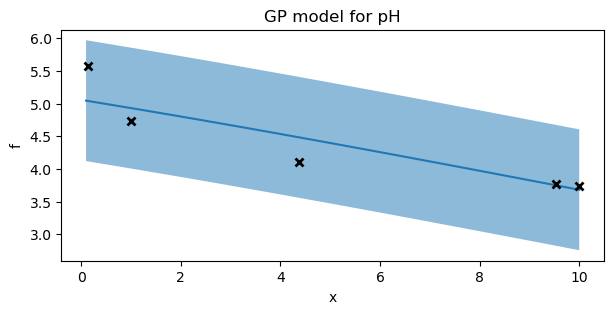

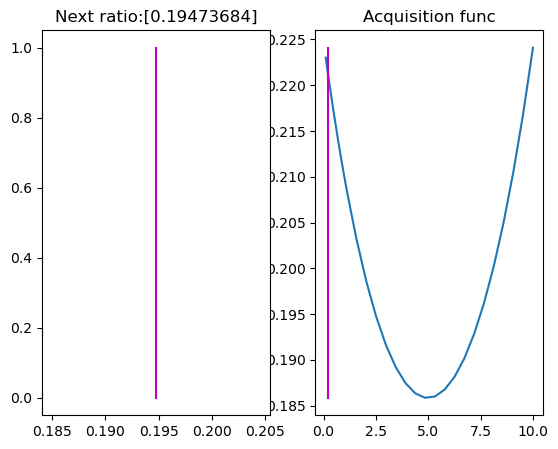

acid_vol 0.3259911894273128
base_vol 1.6740088105726871
pH (HH) [5.45055188]
counter value: 5
Acid/Base ratio measured: [0.19473684]
pH Value: [5.45055188]
Optimization restart 1/5, f = 7.577874534952723
Optimization restart 2/5, f = 7.577874534952883
Optimization restart 3/5, f = 7.5778745353657815
Optimization restart 4/5, f = 7.462490734390587
Optimization restart 5/5, f = 8.23767041666134
The next ratio to investigate is [9.06315789]


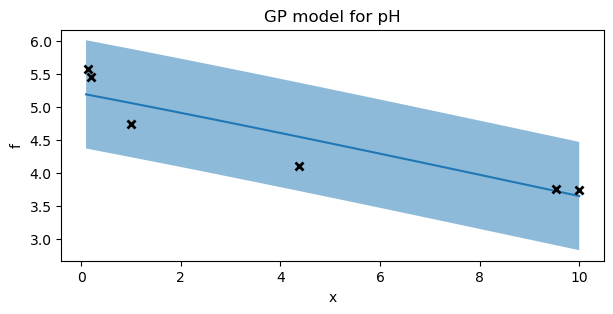

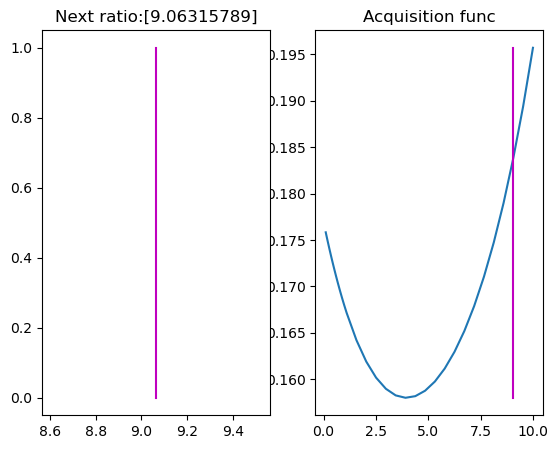

acid_vol 1.8012552301255231
base_vol 0.19874476987447687
pH (HH) [3.78272045]
counter value: 6
Acid/Base ratio measured: [9.06315789]
pH Value: [3.78272045]
Optimization restart 1/5, f = 7.164984641335229
Optimization restart 2/5, f = 7.164984641450906
Optimization restart 3/5, f = 7.164984641600146
Optimization restart 4/5, f = 7.164984642387832
Optimization restart 5/5, f = 7.16498464170012
The next ratio to investigate is [5.31578947]


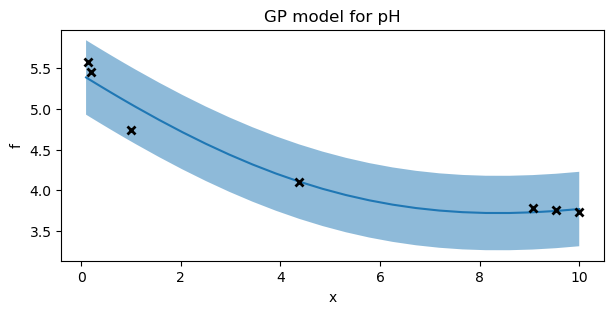

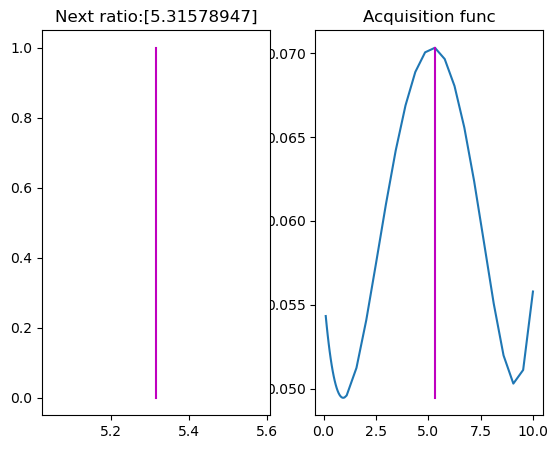

acid_vol 1.6833333333333333
base_vol 0.31666666666666665
pH (HH) [4.01443223]
counter value: 7
Acid/Base ratio measured: [5.31578947]
pH Value: [4.01443223]
Optimization restart 1/5, f = 6.754058814897755
Optimization restart 2/5, f = 6.7540588196193685
Optimization restart 3/5, f = 6.754058814799275
Optimization restart 4/5, f = 6.754058815050206
Optimization restart 5/5, f = 6.754058814814506
The next ratio to investigate is [4.84736842]


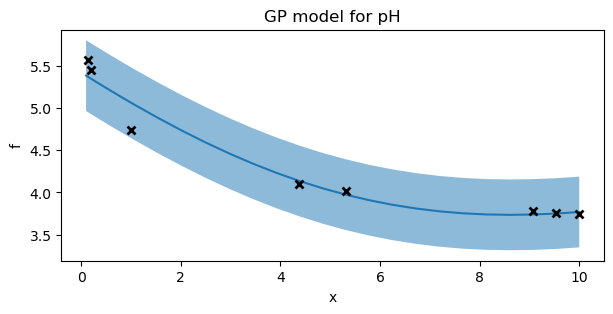

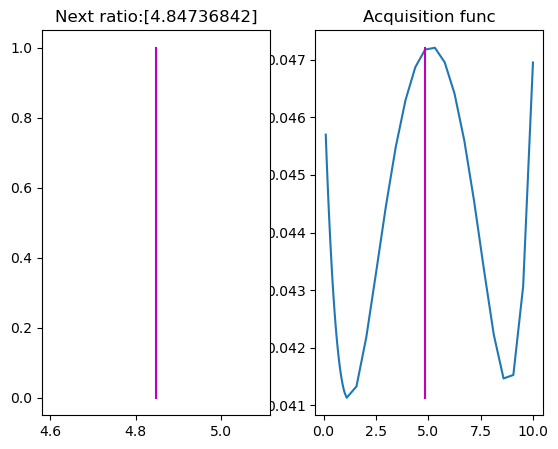

acid_vol 1.657965796579658
base_vol 0.3420342034203421
pH (HH) [4.05449397]
counter value: 8
Acid/Base ratio measured: [4.84736842]
pH Value: [4.05449397]
Optimization restart 1/5, f = 6.097263663166102
Optimization restart 2/5, f = 6.097263663152567
Optimization restart 3/5, f = 6.0972636631531145
Optimization restart 4/5, f = 6.097263663223299
Optimization restart 5/5, f = 4.658512275409713
The next ratio to investigate is [7.18947368]


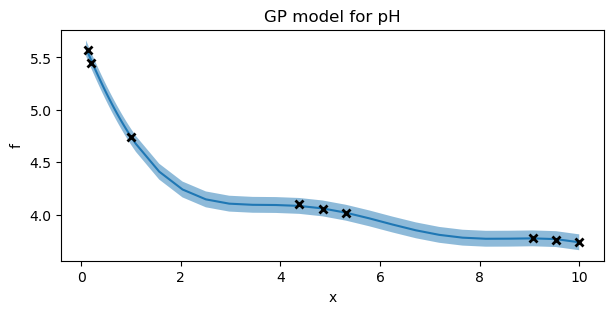

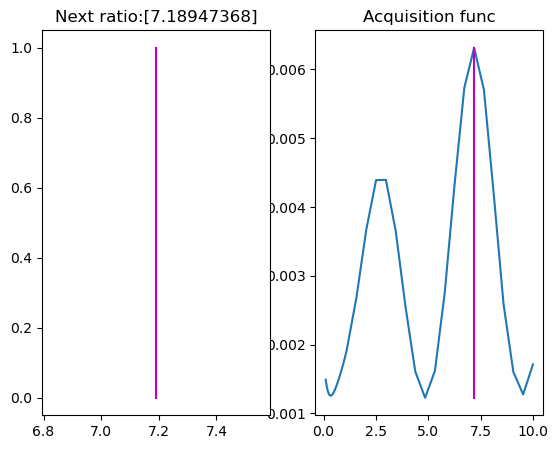

acid_vol 1.755784061696658
base_vol 0.24421593830334198
pH (HH) [3.8833029]
counter value: 9
Acid/Base ratio measured: [7.18947368]
pH Value: [3.8833029]
Optimization restart 1/5, f = 5.470304439587538
Optimization restart 2/5, f = 5.47030443964134
Optimization restart 3/5, f = 5.465442303852711
Optimization restart 4/5, f = 5.470304439762289
Optimization restart 5/5, f = 5.465442267822539
The next ratio to investigate is [2.50526316]


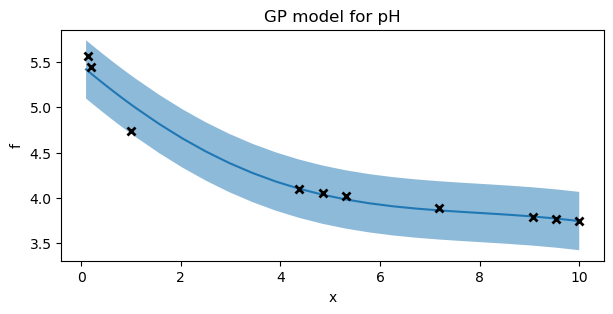

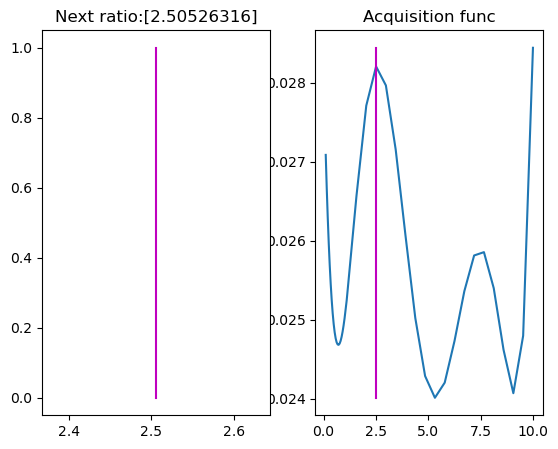

acid_vol 1.4294294294294294
base_vol 0.5705705705705706
pH (HH) [4.34114665]
counter value: 10
Acid/Base ratio measured: [2.50526316]
pH Value: [4.34114665]
Optimization restart 1/5, f = 4.502965563797609
Optimization restart 2/5, f = 4.502965563819188
Optimization restart 3/5, f = 4.502965563790109
Optimization restart 4/5, f = 4.794385714796406
Optimization restart 5/5, f = 4.502965563987484
The next ratio to investigate is [8.12631579]


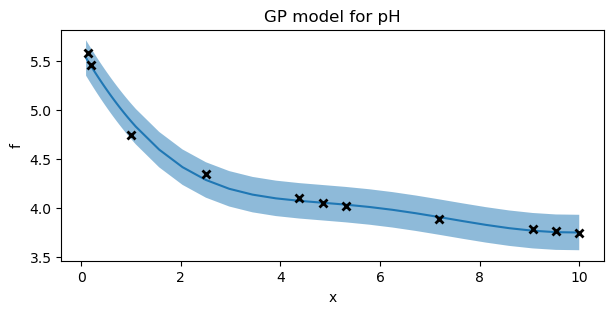

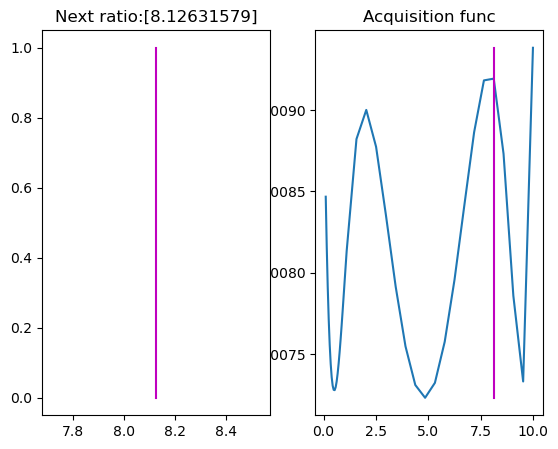

acid_vol 1.7808535178777394
base_vol 0.21914648212226062
pH (HH) [3.8301063]
counter value: 11
Acid/Base ratio measured: [8.12631579]
pH Value: [3.8301063]
Optimization restart 1/5, f = 3.019413139648223
Optimization restart 2/5, f = 3.019413139976294
Optimization restart 3/5, f = 3.019413139617286
Optimization restart 4/5, f = 3.0194131396128903
Optimization restart 5/5, f = 3.019413139610986
The next ratio to investigate is [2.03684211]


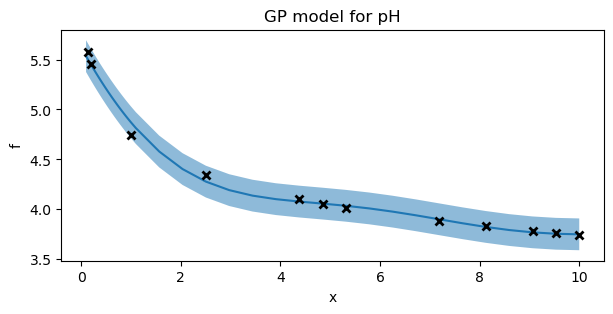

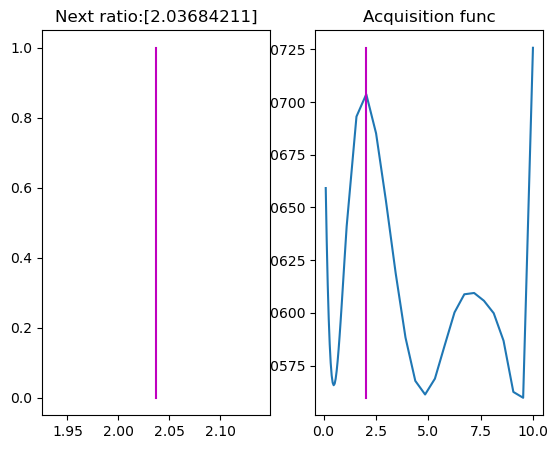

acid_vol 1.341421143847487
base_vol 0.658578856152513
pH (HH) [4.43104264]
counter value: 12
Acid/Base ratio measured: [2.03684211]
pH Value: [4.43104264]
Optimization restart 1/5, f = 1.4912611331919905
Optimization restart 2/5, f = 1.4912611330057608
Optimization restart 3/5, f = 1.4912611331874333
Optimization restart 4/5, f = 1.4912611330156285
Optimization restart 5/5, f = 1.4912611329974776
The next ratio to investigate is [6.72105263]


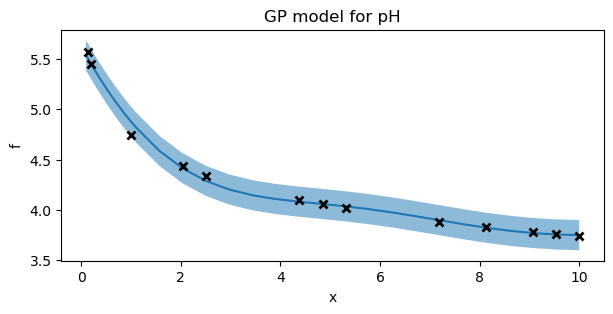

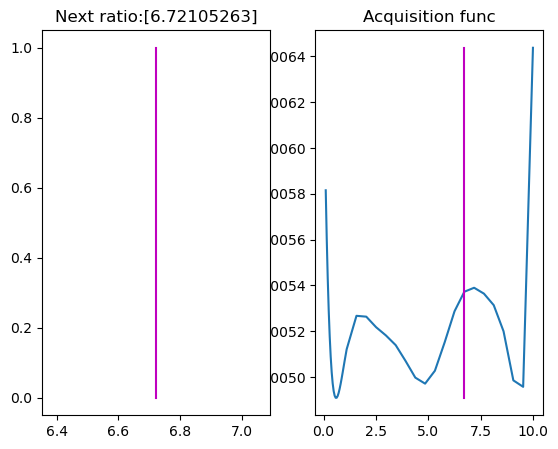

acid_vol 1.7409679618268576
base_vol 0.25903203817314235
pH (HH) [3.9125627]
counter value: 13
Acid/Base ratio measured: [6.72105263]
pH Value: [3.9125627]
Optimization restart 1/5, f = -1.0825354667721854
Optimization restart 2/5, f = -0.2593808132618731
Optimization restart 3/5, f = -1.082535466919552
Optimization restart 4/5, f = -0.25938081325970863
Optimization restart 5/5, f = -0.25938081326280216
The next ratio to investigate is [3.44210526]


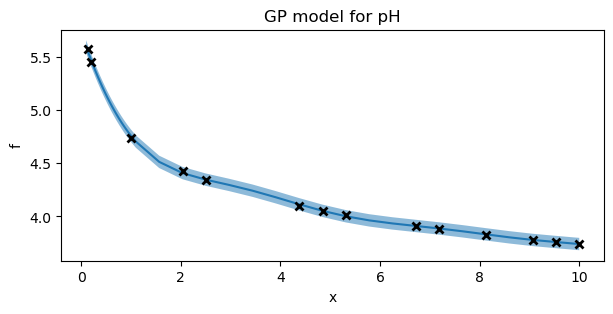

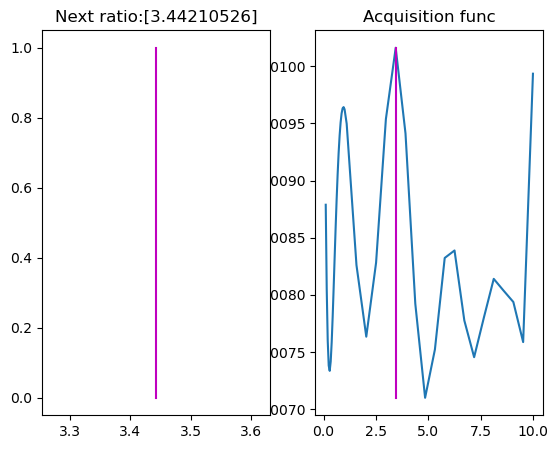

acid_vol 1.5497630331753554
base_vol 0.45023696682464465
pH (HH) [4.20317585]
counter value: 14
Acid/Base ratio measured: [3.44210526]
pH Value: [4.20317585]
Optimization restart 1/5, f = -2.8647716262014864
Optimization restart 2/5, f = -2.86477162644651
Optimization restart 3/5, f = -2.8647716263755125
Optimization restart 4/5, f = -2.8647716264162195
Optimization restart 5/5, f = -2.8647716264166245
The next ratio to investigate is [0.95263158]


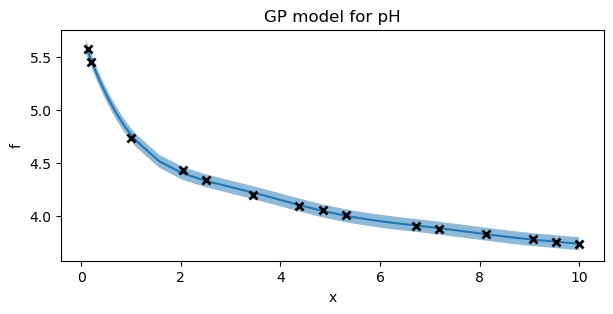

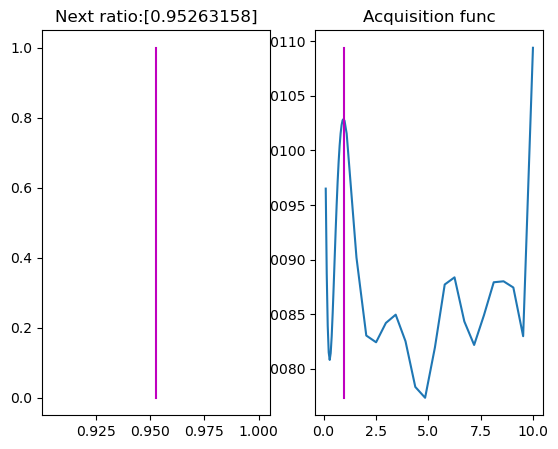

acid_vol 0.9757412398921832
base_vol 1.0242587601078168
pH (HH) [4.76107503]
counter value: 15
Acid/Base ratio measured: [0.95263158]
pH Value: [4.76107503]
Optimization restart 1/5, f = -4.977212657455041
Optimization restart 2/5, f = -4.977212657526039
Optimization restart 3/5, f = -4.977212656962767
Optimization restart 4/5, f = -4.977212656961267
Optimization restart 5/5, f = -4.977212657444603
The next ratio to investigate is [6.25263158]


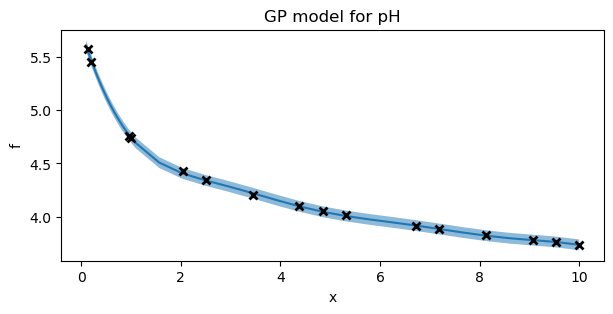

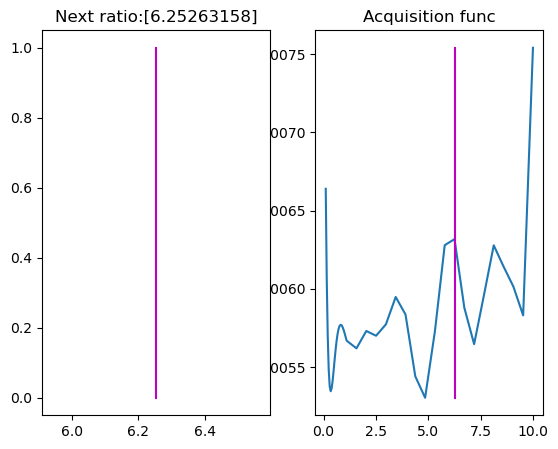

acid_vol 1.7242380261248187
base_vol 0.2757619738751813
pH (HH) [3.94393716]
counter value: 16
Acid/Base ratio measured: [6.25263158]
pH Value: [3.94393716]
Optimization restart 1/5, f = -7.76397057750194
Optimization restart 2/5, f = -7.763970577563757
Optimization restart 3/5, f = -7.763970577499702
Optimization restart 4/5, f = -7.763970577569108
Optimization restart 5/5, f = -7.763970577080983
The next ratio to investigate is [8.59473684]


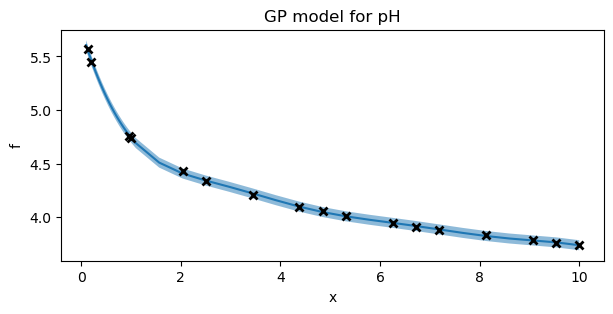

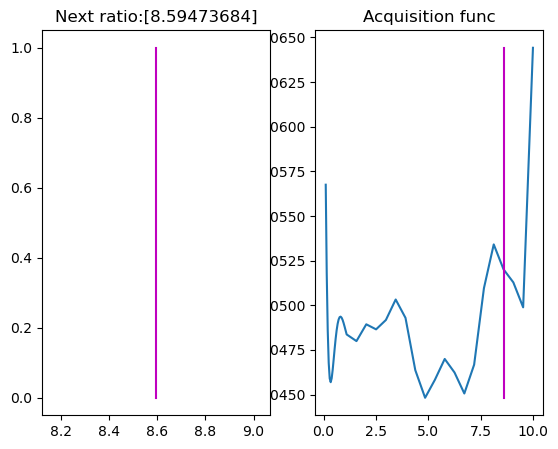

acid_vol 1.7915523861766318
base_vol 0.20844761382336818
pH (HH) [3.80576742]
counter value: 17
Acid/Base ratio measured: [8.59473684]
pH Value: [3.80576742]
Optimization restart 1/5, f = -10.649525118076514
Optimization restart 2/5, f = -10.649525118114322
Optimization restart 3/5, f = -10.649525118053347
Optimization restart 4/5, f = -10.649525118135852
Optimization restart 5/5, f = -10.64952511812357
The next ratio to investigate is [3.91052632]


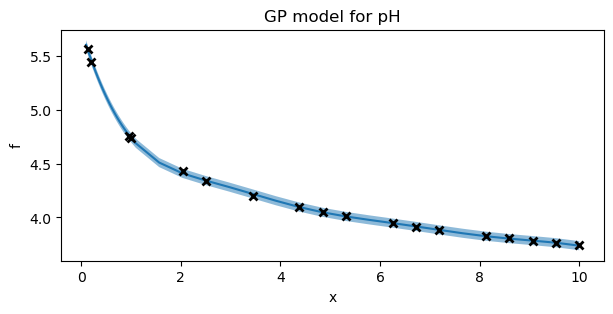

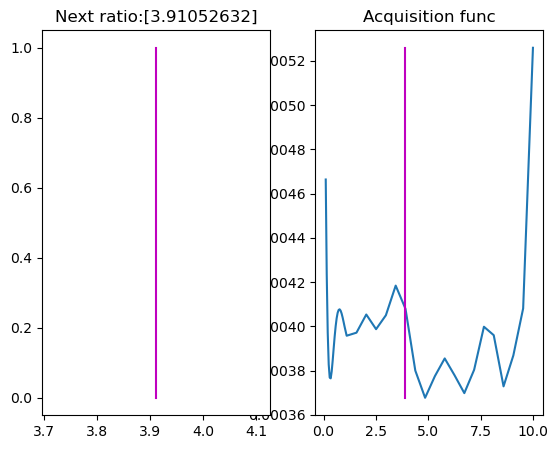

acid_vol 1.5927116827438372
base_vol 0.40728831725616277
pH (HH) [4.14776479]
counter value: 18
Acid/Base ratio measured: [3.91052632]
pH Value: [4.14776479]
Optimization restart 1/5, f = -13.662340137047863
Optimization restart 2/5, f = -13.662340136962136
Optimization restart 3/5, f = -13.662340136967217
Optimization restart 4/5, f = -13.662340137093672
Optimization restart 5/5, f = -13.662340137086776
The next ratio to investigate is [0.71578947]


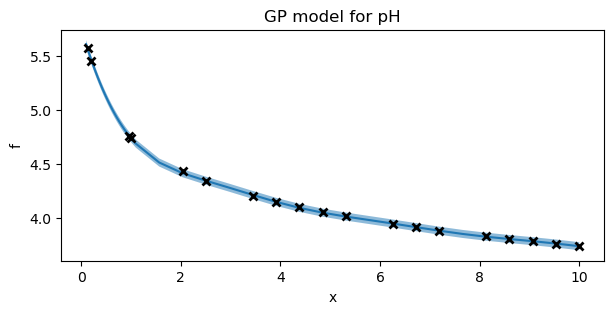

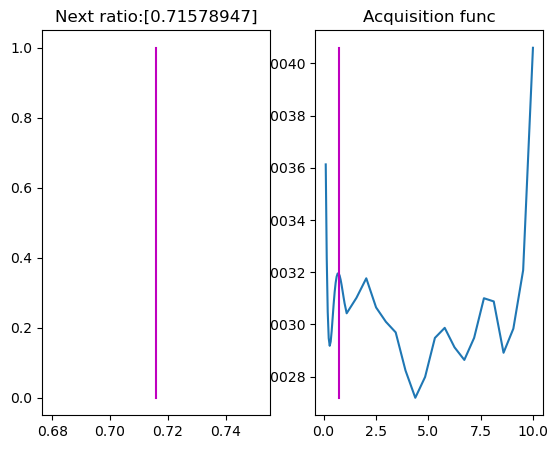

acid_vol 0.8343558282208589
base_vol 1.165644171779141
pH (HH) [4.88521469]
counter value: 19
Acid/Base ratio measured: [0.71578947]
pH Value: [4.88521469]
Optimization restart 1/5, f = -13.719714202245903
Optimization restart 2/5, f = -13.719714202117359
Optimization restart 3/5, f = -13.71971420218324
Optimization restart 4/5, f = -13.719714202193678
Optimization restart 5/5, f = -13.719714201176565
The next ratio to investigate is [7.65789474]


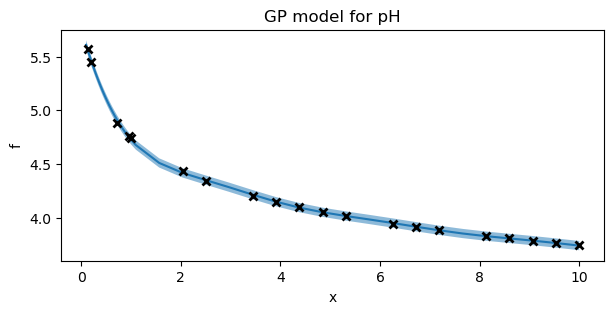

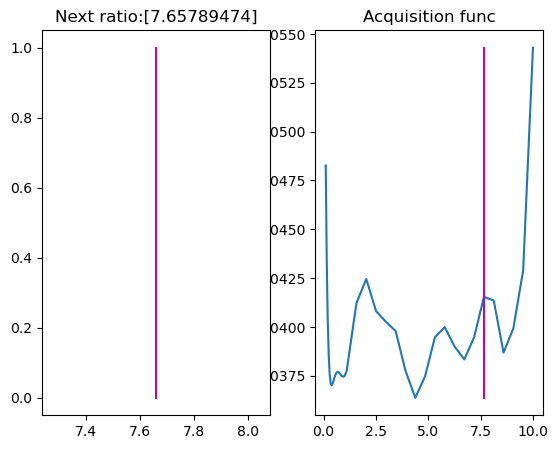

acid_vol 1.7689969604863223
base_vol 0.23100303951367773
pH (HH) [3.85589061]
counter value: 20
Acid/Base ratio measured: [7.65789474]
pH Value: [3.85589061]
Optimization restart 1/5, f = -16.701526703376317
Optimization restart 2/5, f = -16.70152670144011
Optimization restart 3/5, f = -16.701526703543813
Optimization restart 4/5, f = -16.701526703374366
Optimization restart 5/5, f = -16.70152670338374
The next ratio to investigate is [1.56842105]


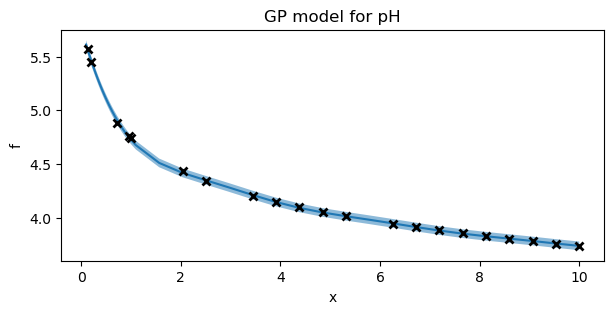

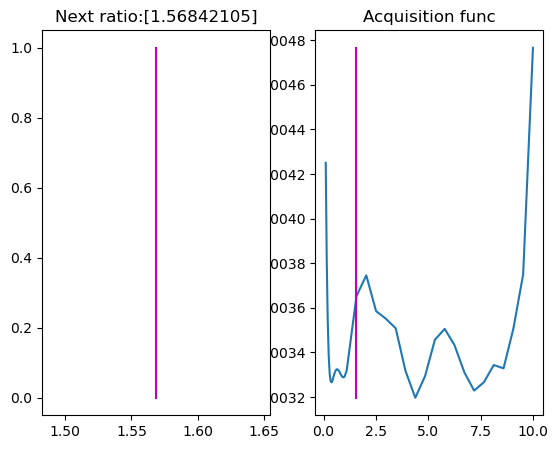

acid_vol 1.221311475409836
base_vol 0.778688524590164
pH (HH) [4.54453734]
counter value: 21
Acid/Base ratio measured: [1.56842105]
pH Value: [4.54453734]
Optimization restart 1/5, f = -18.27393060482681
Optimization restart 2/5, f = -18.273930604338553
Optimization restart 3/5, f = -18.273930604726957
Optimization restart 4/5, f = -18.273930604556234
Optimization restart 5/5, f = -18.273930604800576
The next ratio to investigate is [2.97368421]


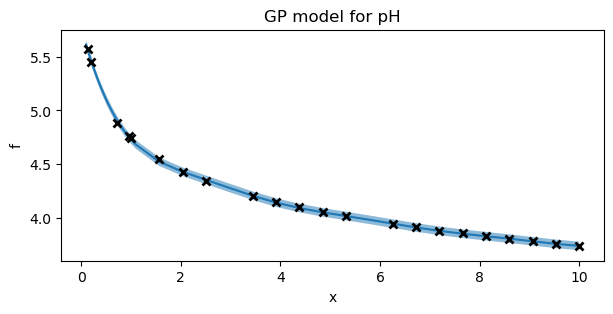

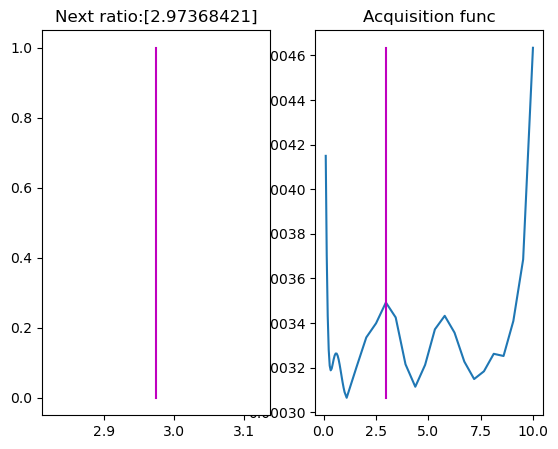

acid_vol 1.4966887417218544
base_vol 0.5033112582781456
pH (HH) [4.26670515]
counter value: 22
Acid/Base ratio measured: [2.97368421]
pH Value: [4.26670515]
Optimization restart 1/5, f = -21.138697677719335
Optimization restart 2/5, f = -21.138697677620726
Optimization restart 3/5, f = -21.138697677596568
Optimization restart 4/5, f = -21.13869767780723
Optimization restart 5/5, f = -21.138697675912184
The next ratio to investigate is [5.78421053]


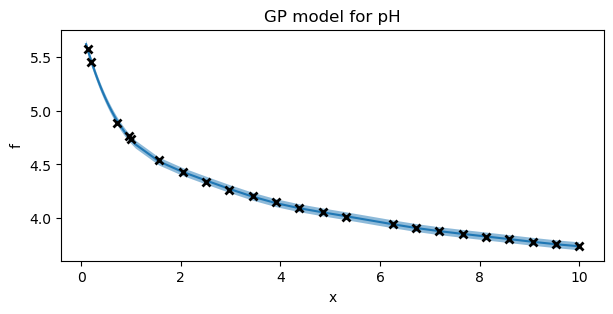

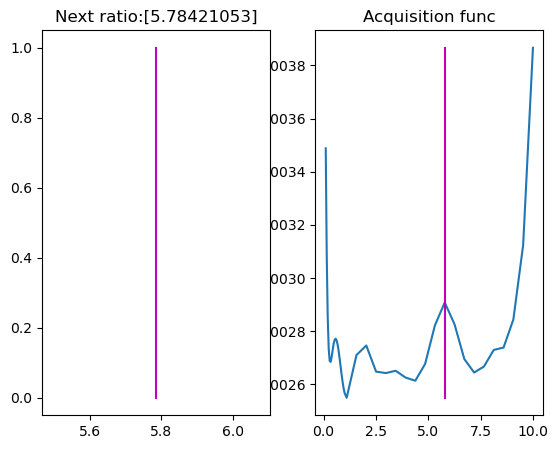

acid_vol 1.7051978277734678
base_vol 0.29480217222653216
pH (HH) [3.97775591]
counter value: 23
Acid/Base ratio measured: [5.78421053]
pH Value: [3.97775591]
Optimization restart 1/5, f = -24.301527942800917
Optimization restart 2/5, f = -24.30152794291726
Optimization restart 3/5, f = -24.30152794271207
Optimization restart 4/5, f = -24.30152794210626
Optimization restart 5/5, f = -24.301527943191402
The next ratio to investigate is [0.57368421]


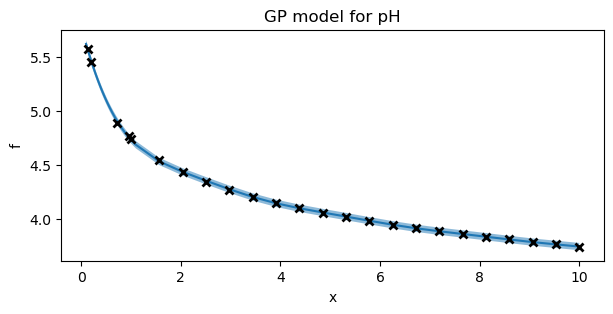

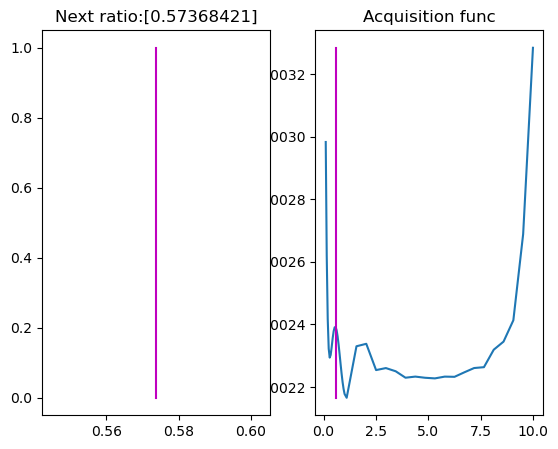

acid_vol 0.7290969899665551
base_vol 1.2709030100334449
pH (HH) [4.9813271]
counter value: 24
Acid/Base ratio measured: [0.57368421]
pH Value: [4.9813271]
Optimization restart 1/5, f = -23.496720117024466
Optimization restart 2/5, f = -23.496720115156947
Optimization restart 3/5, f = -23.49672011685915
Optimization restart 4/5, f = -23.49672011726436
Optimization restart 5/5, f = -23.496720117186356
The next ratio to investigate is [0.24210526]


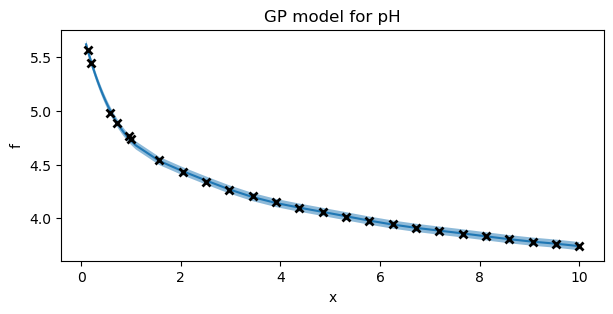

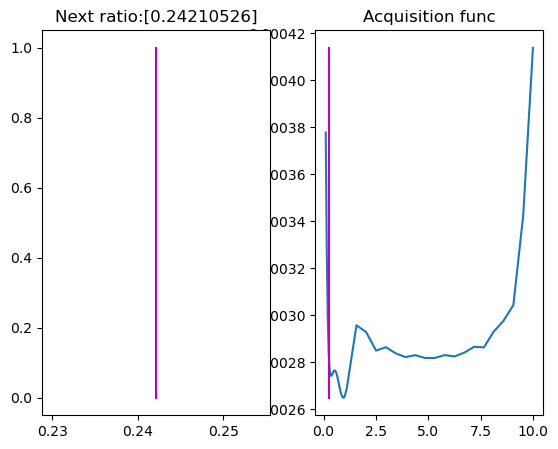

acid_vol 0.38983050847457623
base_vol 1.6101694915254239
pH (HH) [5.35599577]
counter value: 25
Acid/Base ratio measured: [0.24210526]
pH Value: [5.35599577]
Optimization restart 1/5, f = -24.02359504394702
Optimization restart 2/5, f = -24.0235950447263
Optimization restart 3/5, f = -24.023595044675773
Optimization restart 4/5, f = -24.023595044671595
Optimization restart 5/5, f = -24.023595044654527
The next ratio to investigate is [0.66842105]


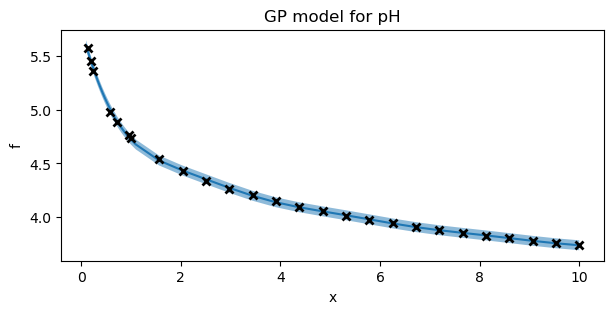

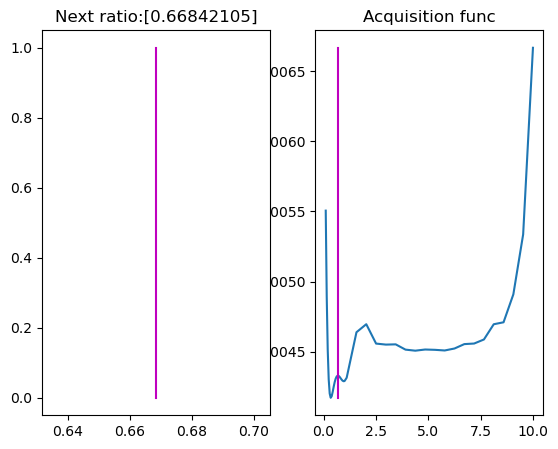

acid_vol 0.8012618296529967
base_vol 1.1987381703470033
pH (HH) [4.91494988]
counter value: 26
Acid/Base ratio measured: [0.66842105]
pH Value: [4.91494988]
Optimization restart 1/5, f = -26.662420590280973
Optimization restart 2/5, f = -26.66242059482316
Optimization restart 3/5, f = -26.662420595205987
Optimization restart 4/5, f = -26.662420595162814
Optimization restart 5/5, f = -26.662420594879265
The next ratio to investigate is [1.1]


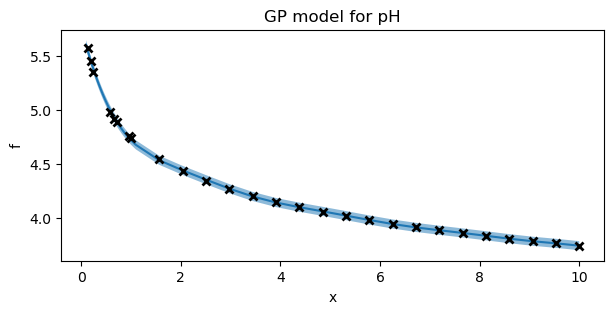

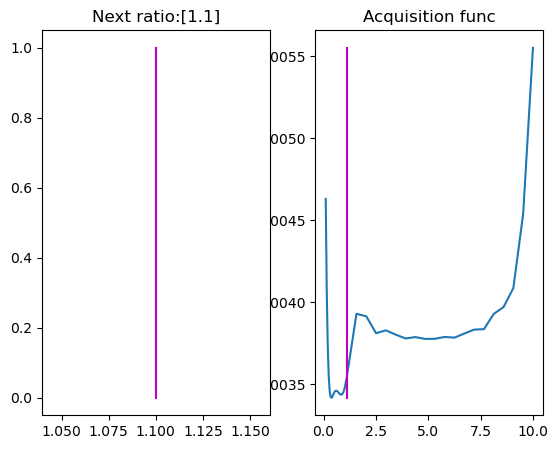

acid_vol 1.0476190476190477
base_vol 0.9523809523809523
pH (HH) [4.69860731]
counter value: 27
Acid/Base ratio measured: [1.1]
pH Value: [4.69860731]
Optimization restart 1/5, f = -29.0021631865583
Optimization restart 2/5, f = -29.002163186610197
Optimization restart 3/5, f = -29.002163186520555
Optimization restart 4/5, f = -29.002163186489575
Optimization restart 5/5, f = -29.00216318665992
The next ratio to investigate is [0.52631579]


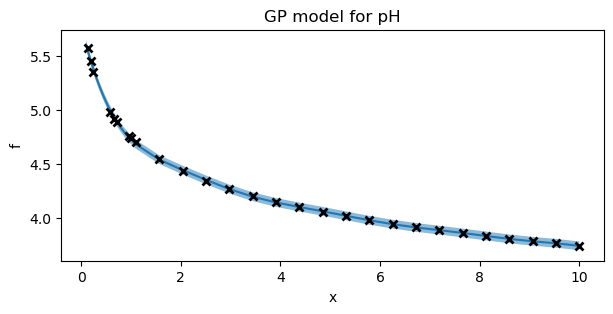

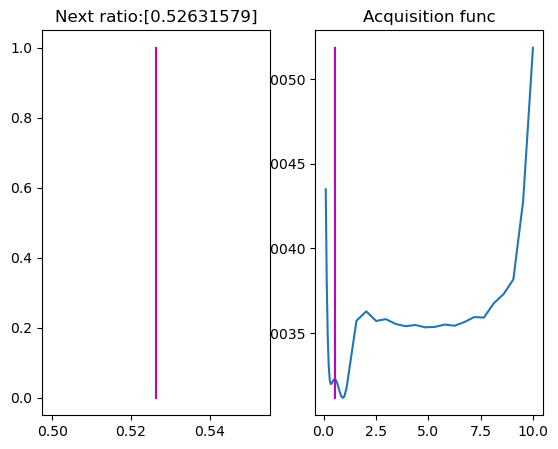

acid_vol 0.6896551724137931
base_vol 1.3103448275862069
pH (HH) [5.0187536]
counter value: 28
Acid/Base ratio measured: [0.52631579]
pH Value: [5.0187536]
Optimization restart 1/5, f = -30.768642333770387
Optimization restart 2/5, f = -30.768642446751215
Optimization restart 3/5, f = -30.768642446911983
Optimization restart 4/5, f = -30.768642445549347
Optimization restart 5/5, f = -30.76864244646123
The next ratio to investigate is [0.47894737]


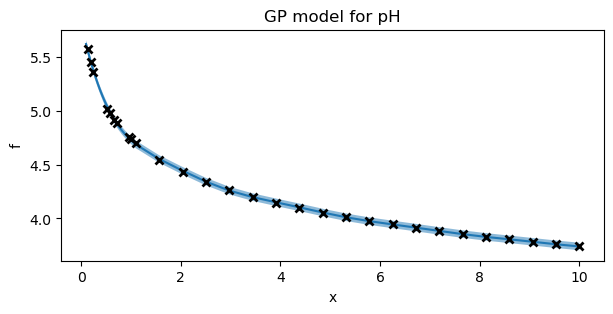

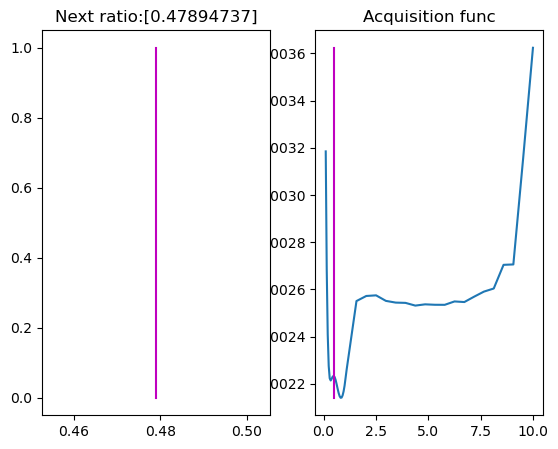

acid_vol 0.6476868327402137
base_vol 1.3523131672597863
pH (HH) [5.05971221]
counter value: 29
Acid/Base ratio measured: [0.47894737]
pH Value: [5.05971221]
Optimization restart 1/5, f = -32.981372343461885
Optimization restart 2/5, f = -32.98137234353426
Optimization restart 3/5, f = -32.981372343174556
Optimization restart 4/5, f = -32.98137234375007
Optimization restart 5/5, f = -32.98137234336414
The next ratio to investigate is [1.]


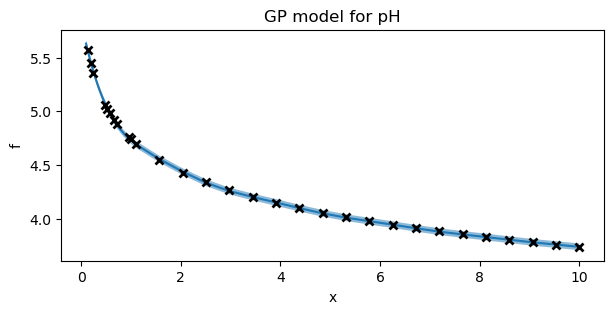

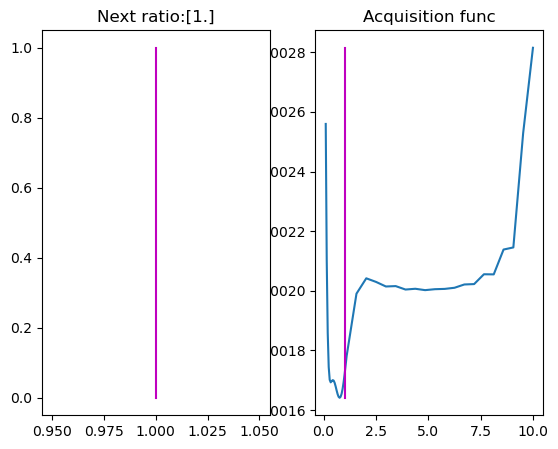

acid_vol 1.0
base_vol 1.0
pH (HH) [4.74]
counter value: 30
Acid/Base ratio measured: [1.]
pH Value: [4.74]


In [54]:
Bayesian_optimization_pH()